# DFT Pipeline for NIEL Calculations

flow: check dependencies -> import libs -> set config -> load dataset -> generate QE input -> run vc-relax -> extract relaxed structure & density -> compute NIEL (Coulomb + nuclear elastic) for OMERE

## 1. Dependencies and imports

In [1]:
import importlib, shutil, os
import pandas as pd
from IPython.display import display

check_data = []

for pkg in ["numpy", "ase", "jarvis", "nglview", "seaborn", "pandas"]:
    try:
        mod = importlib.import_module(pkg)
        version = getattr(mod, '__version__', 'N/A')
        check_data.append({'Category': 'Package', 'Item': pkg, 'Status': 'OK', 'Details': version})
    except ImportError:
        check_data.append({'Category': 'Package', 'Item': pkg, 'Status': 'MISSING', 'Details': 'Not installed'})

for exe in ["pw.x", "mpirun"]:
    found = shutil.which(exe)
    status = 'OK' if found else 'MISSING'
    details = found if found else 'Not in PATH'
    check_data.append({'Category': 'Executable', 'Item': exe, 'Status': status, 'Details': details})

pseudo_dir = "/usr/share/espresso/pseudo"
if os.path.isdir(pseudo_dir):
    num_pseudos = len([f for f in os.listdir(pseudo_dir) if f.endswith(('.upf', '.UPF'))])
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'Directory', 'Status': 'OK', 'Details': pseudo_dir})
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'File count', 'Status': 'OK', 'Details': f'{num_pseudos} files'})
else:
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'Directory', 'Status': 'MISSING', 'Details': 'Not found'})

display(pd.DataFrame(check_data))

,Category,Item,Status,Details
0,Package,numpy,OK,1.26.4
1,Package,ase,OK,3.27.0
2,Package,jarvis,OK,2026.1.10
3,Package,nglview,OK,4.0
4,Package,seaborn,OK,0.13.2
5,Package,pandas,OK,3.0.0
6,Executable,pw.x,OK,/home/vm/miniconda3/envs/DSI/bin/pw.x
7,Executable,mpirun,OK,/home/vm/miniconda3/envs/DSI/bin/mpirun
8,Pseudopotentials,Directory,OK,/usr/share/espresso/pseudo
9,Pseudopotentials,File count,OK,93 files


In [2]:
import os
import sys

# ensure conda libs are in ld_library_path for subprocess calls
conda_prefix = os.environ.get('CONDA_PREFIX', os.path.expanduser('~/miniconda3/envs/DSI'))
lib_path = os.path.join(conda_prefix, 'lib')
os.environ['LD_LIBRARY_PATH'] = lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')

import numpy as np
import pandas as pd
from IPython.display import display, HTML
from jarvis.db.figshare import data as jarvis_data
from jarvis.core.atoms import Atoms as JarvisAtoms
from ase import Atoms as AseAtoms
import nglview as nv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import subprocess
import multiprocessing

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

## 2. Config

In [3]:
JARVIS_DATABASE = "dft_3d"
WORK_DIR = os.path.join(os.getcwd(), "calculations")
os.makedirs(WORK_DIR, exist_ok=True)

QE_PSEUDOPOTENTIALS_DIR = pseudo_dir
QE_EXECUTABLE = shutil.which("pw.x") or shutil.which("pw")
MPI_EXECUTABLE = shutil.which("mpirun") or shutil.which("mpiexec")

# memory constraints - adjust SYSTEM_RAM_GB for your machine
SYSTEM_RAM_GB = 16
MAX_ATOMS = {8: 2, 16: 6, 32: 12, 64: 25, 128: 50}.get(SYSTEM_RAM_GB, int(SYSTEM_RAM_GB * 0.4))

OCCUPATIONS = "smearing"
SMEARING = "cold"
DEGAUSS = 0.01

# precision settings
ENABLE_VDW = True       # van der Waals correction (DFT-D3, negligible cost)
ENABLE_RELAX = True     # structural relaxation (vc-relax) before SCF
CONV_THR_RELAX = 1.0e-6 # convergence threshold for relaxation
FORC_CONV_THR = 1.0e-4  # force convergence for relaxation (Ry/bohr)
PRESS_CONV_THR = 0.1    # pressure convergence for relaxation (kbar)

print(f"system ram: {SYSTEM_RAM_GB} GB, max atoms: {MAX_ATOMS}")
print(f"executables: pw.x={QE_EXECUTABLE is not None}")
print(f"pseudopotentials: {QE_PSEUDOPOTENTIALS_DIR}")
print(f"precision: vdW={ENABLE_VDW}, relax={ENABLE_RELAX}")
print(f"conv_thr: relax={CONV_THR_RELAX}")
print("\n(nprocs, cutoffs, k-points computed after material is loaded)")

system ram: 16 GB, max atoms: 6
executables: pw.x=True
pseudopotentials: /usr/share/espresso/pseudo
precision: vdW=True, relax=True
conv_thr: relax=1e-06

(nprocs, cutoffs, k-points computed after material is loaded)


## 3. Load Material from JARVIS

In [4]:
data = jarvis_data(JARVIS_DATABASE)
candidates = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "calculating_energy_threshold_displacement/candidate_materials.csv"))

MATERIAL_INDEX = 0  # change to process different materials
formula = candidates.iloc[MATERIAL_INDEX]['formula']
mat = next((m for m in data if m.get('formula') == formula), None)
MATERIAL_ID = mat['jid']

print(f"{MATERIAL_INDEX}: {formula} -> {MATERIAL_ID}")

jarvis_atoms = JarvisAtoms.from_dict(mat['atoms'])
ase_atoms = AseAtoms(
    symbols=jarvis_atoms.elements,
    positions=jarvis_atoms.cart_coords,
    cell=jarvis_atoms.lattice_mat,
    pbc=True
)

# check if material exceeds memory limits
n_atoms = len(ase_atoms)
if n_atoms > MAX_ATOMS:
    raise MemoryError(
        f"material has {n_atoms} atoms, max supported on {SYSTEM_RAM_GB}GB RAM is {MAX_ATOMS}.\n"
        f"try a smaller material or run on a machine with more memory."
    )

# MPI processes for Quantum ESPRESSO
# QE distributes memory across processes, so MORE processes = LESS ram per process
# small systems: limited by parallelization efficiency (overhead dominates)
# large systems: need MORE processes to distribute memory, not fewer!
available_cores = multiprocessing.cpu_count()
ram_per_core = SYSTEM_RAM_GB / available_cores

if n_atoms <= 2:
    # small systems: parallel efficiency drops with too many cores, but memory is fine
    # use up to half the cores to balance speed vs overhead
    QE_NPROCS = min(available_cores // 2, 4) or 1
elif n_atoms <= 6:
    # medium systems: can use most cores effectively
    QE_NPROCS = min(available_cores - 1, 8)
else:
    # large systems: NEED more processes to distribute memory load
    # each process gets a fraction of the FFT grid
    QE_NPROCS = available_cores

# ensure at least 2GB per process for QE overhead
min_ram_per_proc = 2.0
max_procs_for_ram = max(1, int(SYSTEM_RAM_GB / min_ram_per_proc))
QE_NPROCS = min(QE_NPROCS, max_procs_for_ram)

print(f"atoms: {n_atoms} (max {MAX_ATOMS} for {SYSTEM_RAM_GB}GB RAM)")
print(f"mpi processes: {QE_NPROCS} (of {available_cores} cores, ~{SYSTEM_RAM_GB/QE_NPROCS:.1f}GB per process)")

Obtaining 3D dataset 76k ...
Reference:https://doi.org/10.1016/j.commatsci.2025.114063
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
0: InP -> JVASP-1183
atoms: 2 (max 6 for 16GB RAM)
mpi processes: 4 (of 10 cores, ~4.0GB per process)


In [5]:
elements = list(set(ase_atoms.get_chemical_symbols()))
element_counts = {e: ase_atoms.get_chemical_symbols().count(e) for e in elements}

mat_props = [
    {'Property': 'Material ID', 'Value': MATERIAL_ID},
    {'Property': 'Formula', 'Value': ase_atoms.get_chemical_formula()},
    {'Property': 'Atoms', 'Value': len(ase_atoms)},
    {'Property': 'Elements', 'Value': str(element_counts)},
    {'Property': 'Volume', 'Value': f'{ase_atoms.get_volume():.3f} A^3'},
    {'Property': 'Cell', 'Value': f'{ase_atoms.cell.lengths()[0]:.3f} x {ase_atoms.cell.lengths()[1]:.3f} x {ase_atoms.cell.lengths()[2]:.3f} A'},
]

for key in ['formation_energy_peratom', 'optb88vdw_bandgap', 'spillage']:
    if key in mat and mat[key] is not None:
        val = mat[key]
        mat_props.append({'Property': key, 'Value': f'{val:.4f}' if isinstance(val, (int, float)) else str(val)})

display(pd.DataFrame(mat_props))

,Property,Value
0,Material ID,JVASP-1183
1,Formula,InP
2,Atoms,2
3,Elements,"{'P': 1, 'In': 1}"
4,Volume,52.799 A^3
5,Cell,4.211 x 4.211 x 4.211 A
6,formation_energy_peratom,-0.2243
7,optb88vdw_bandgap,0.3310
8,spillage,na


In [6]:
from ase.build import make_supercell

supercell = make_supercell(ase_atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
view = nv.show_ase(supercell)
view.add_unitcell()
view.center()
view

NGLWidget()

## 4. Generate Quantum ESPRESSO Input Files

In [7]:
# parse upf pseudopotential header to extract valence, angular momentum, type
def parse_upf_header(upf_path):
    info = {'z_valence': None, 'l_max': None, 'pseudo_type': None, 'element': None, 'has_so': False}
    with open(upf_path, 'r') as f:
        content = f.read()
    header_match = re.search(r'<PP_HEADER([^>]+)>', content, re.DOTALL)
    if header_match:
        header = header_match.group(1)
        for key in ['z_valence', 'l_max', 'pseudo_type', 'element']:
            match = re.search(rf'{key}="([^"]+)"', header)
            if match:
                val = match.group(1).strip()
                info[key] = float(val) if key in ['z_valence', 'l_max'] else val
    return info

# estimate cutoffs from element properties
def get_recommended_cutoffs(element, z_valence, l_max, pseudo_type):
    from ase.data import atomic_numbers
    Z = atomic_numbers.get(element, 30)
    row = 1 + (Z > 2) + (Z > 10) + (Z > 18) + (Z > 36) + (Z > 54) + (Z > 86)
    
    base_wfc = 30.0
    if l_max is not None:
        base_wfc += l_max * 8.0
    if z_valence is not None:
        base_wfc += z_valence * 1.5
    base_wfc += (row - 1) * 3.0
    
    rho_multiplier = 10.0 if pseudo_type == 'PAW' else 4.0
    ecutwfc = max(40.0, round(base_wfc / 5) * 5)
    ecutrho = ecutwfc * rho_multiplier
    return ecutwfc, ecutrho

# calculate k-point grid from cell size
def get_kpoints_from_cell(cell, density=0.10, max_total_kpts=500):
    recip = 2 * np.pi * np.linalg.inv(cell).T
    recip_lengths = np.linalg.norm(recip, axis=1)
    kpts = [max(1, int(np.ceil(length / density))) for length in recip_lengths]
    total = kpts[0] * kpts[1] * kpts[2]
    if total > max_total_kpts:
        scale = (max_total_kpts / total) ** (1/3)
        kpts = [max(1, int(k * scale)) for k in kpts]
    return kpts

# collect pseudopotentials and compute parameters
elements = list(set(ase_atoms.get_chemical_symbols()))
pseudos = {}
pp_info = {}
cutoffs_wfc = []
cutoffs_rho = []

for e in elements:
    cands = [f for f in os.listdir(QE_PSEUDOPOTENTIALS_DIR) 
             if f.lower().endswith('.upf') and f.startswith(e + '.')]
    if not cands:
        raise FileNotFoundError(f"no pseudopotential for '{e}' in {QE_PSEUDOPOTENTIALS_DIR}")
    non_sp = [c for c in cands if '_sp' not in c]
    pp_file = non_sp[0] if non_sp else cands[0]
    pseudos[e] = pp_file
    
    pp_path = os.path.join(QE_PSEUDOPOTENTIALS_DIR, pp_file)
    info = parse_upf_header(pp_path)
    pp_info[e] = info
    
    wfc, rho = get_recommended_cutoffs(e, info['z_valence'], info['l_max'], info['pseudo_type'])
    cutoffs_wfc.append(wfc)
    cutoffs_rho.append(rho)

ECUTWFC = max(cutoffs_wfc)
ECUTRHO = max(cutoffs_rho)
K_POINTS = get_kpoints_from_cell(ase_atoms.cell)

print("pseudopotentials and parameters:")
for e in elements:
    info = pp_info[e]
    wfc, rho = get_recommended_cutoffs(e, info['z_valence'], info['l_max'], info['pseudo_type'])
    print(f"  {e}: {pseudos[e]}, z={info['z_valence']}, l_max={int(info['l_max']) if info['l_max'] else '?'}, "
          f"cutoff={wfc}/{rho} Ry")

print(f"\ncutoffs: {ECUTWFC}/{ECUTRHO} Ry")
print(f"k-points: {K_POINTS} = {K_POINTS[0]*K_POINTS[1]*K_POINTS[2]} pts")
print(f"vdW: {ENABLE_VDW}, relax: {ENABLE_RELAX}")

def generate_qe_input(calc_type, k_grid, atoms, material_id, pseudos):
    """generate QE input for vc-relax calculation."""
    lines = [
        f"&CONTROL\n  calculation='{calc_type}'\n  prefix='{material_id}'\n",
        f"  outdir='./tmp'\n  pseudo_dir='{QE_PSEUDOPOTENTIALS_DIR}'\n",
    ]
    if calc_type == 'vc-relax':
        lines.append("  forc_conv_thr={:.1e}\n".format(FORC_CONV_THR))
        lines.append("  etot_conv_thr=1.0d-6\n")
    lines.append("/\n")
    
    lines.append(f"&SYSTEM\n  ibrav=0\n  nat={len(atoms)}\n  ntyp={len(elements)}\n")
    lines.append(f"  ecutwfc={ECUTWFC}\n  ecutrho={ECUTRHO}\n")
    lines.append(f"  occupations='{OCCUPATIONS}'\n  smearing='{SMEARING}'\n  degauss={DEGAUSS}\n")
    if ENABLE_VDW:
        lines.append("  vdw_corr='dft-d3'\n")
    lines.append("/\n")
    
    lines.append(f"&ELECTRONS\n  conv_thr={CONV_THR_RELAX:.1e}\n/\n")
    
    if calc_type == 'vc-relax':
        lines.append("&IONS\n  ion_dynamics='bfgs'\n/\n")
        lines.append(f"&CELL\n  cell_dynamics='bfgs'\n  press_conv_thr={PRESS_CONV_THR}\n/\n")
    
    lines.append("ATOMIC_SPECIES\n")
    for e in elements:
        mass = atoms.get_masses()[atoms.get_chemical_symbols().index(e)]
        lines.append(f"  {e}  {mass:.4f}  {pseudos[e]}\n")
    
    lines.append("\nCELL_PARAMETERS angstrom\n")
    for i in range(3):
        lines.append(f"  {atoms.cell[i,0]:16.10f} {atoms.cell[i,1]:16.10f} {atoms.cell[i,2]:16.10f}\n")
    
    lines.append("\nATOMIC_POSITIONS angstrom\n")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.positions):
        lines.append(f"  {s:4s} {p[0]:16.10f} {p[1]:16.10f} {p[2]:16.10f}\n")
    
    lines.append(f"\nK_POINTS automatic\n  {k_grid[0]} {k_grid[1]} {k_grid[2]}  0 0 0\n")
    return ''.join(lines)

qe_relax_input = generate_qe_input('vc-relax', K_POINTS, ase_atoms, MATERIAL_ID, pseudos)

pseudopotentials and parameters:
  P: P.GGA_PBE-JTH.UPF, z=5.0, l_max=1, cutoff=50/500.0 Ry
  In: In.GGA_PBE-JTH.UPF, z=13.0, l_max=2, cutoff=80/800.0 Ry

cutoffs: 80/800.0 Ry
k-points: [7, 7, 7] = 343 pts
vdW: True, relax: True


## 5. Run DFT Structural Relaxation

In [8]:
def run_command(cmd, cwd, timeout=None):
    process = subprocess.Popen(
        cmd, shell=True, cwd=cwd,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        text=True, bufsize=1
    )
    output_lines = []
    try:
        for line in process.stdout:
            print(line, end='', flush=True)
            output_lines.append(line)
        process.wait(timeout=timeout)
    except subprocess.TimeoutExpired:
        process.kill()
        raise
    if process.returncode != 0:
        raise RuntimeError(f"command failed with code {process.returncode}")
    return ''.join(output_lines)

def parse_relaxed_structure(output_text, original_atoms):
    """parse final cell and positions from vc-relax output."""
    cell_blocks = list(re.finditer(
        r'CELL_PARAMETERS\s*\(?\s*angstrom\s*\)?\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)',
        output_text, re.IGNORECASE
    ))
    pos_blocks = list(re.finditer(
        r'ATOMIC_POSITIONS\s*\(?\s*angstrom\s*\)?\s*\n((?:\s*\w+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s*\n?)+)',
        output_text, re.IGNORECASE
    ))
    
    if not cell_blocks or not pos_blocks:
        print("WARNING: could not parse relaxed structure, using original")
        return original_atoms
    
    cell_match = cell_blocks[-1]
    cell = np.array([
        [float(x) for x in cell_match.group(1).split()],
        [float(x) for x in cell_match.group(2).split()],
        [float(x) for x in cell_match.group(3).split()],
    ])
    
    pos_text = pos_blocks[-1].group(1).strip()
    symbols = []
    positions = []
    for line in pos_text.split('\n'):
        parts = line.split()
        if len(parts) >= 4:
            symbols.append(parts[0])
            positions.append([float(parts[1]), float(parts[2]), float(parts[3])])
    
    relaxed = AseAtoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
    print(f"relaxed cell: {relaxed.cell.lengths()[0]:.4f} x {relaxed.cell.lengths()[1]:.4f} x {relaxed.cell.lengths()[2]:.4f} A")
    print(f"original cell: {original_atoms.cell.lengths()[0]:.4f} x {original_atoms.cell.lengths()[1]:.4f} x {original_atoms.cell.lengths()[2]:.4f} A")
    return relaxed

dft_dir = os.path.join(WORK_DIR, f"dft_{MATERIAL_ID}")
os.makedirs(dft_dir, exist_ok=True)

tmp_dir = os.path.join(dft_dir, "tmp")
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
    print(f"cleaned {tmp_dir}")

# structural relaxation — gives us the equilibrium structure and accurate density
atoms_relaxed = ase_atoms
if ENABLE_RELAX:
    with open(os.path.join(dft_dir, f"{MATERIAL_ID}_relax.in"), 'w') as f:
        f.write(qe_relax_input)
    
    print("running vc-relax...")
    relax_output = run_command(
        f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_relax.in",
        cwd=dft_dir
    )
    
    if 'JOB DONE' in relax_output:
        atoms_relaxed = parse_relaxed_structure(relax_output, ase_atoms)
        print("vc-relax completed successfully")
    else:
        print("WARNING: vc-relax did not complete, using original structure")

# compute density from relaxed structure (used in NIEL output)
dft_density = sum(atoms_relaxed.get_masses()) / atoms_relaxed.get_volume() * 1.66054  # g/cm³
print(f"\nDFT-relaxed density: {dft_density:.4f} g/cm³")

cleaned /home/vm/LUMENS-PV/calculating_energy_threshold_displacement/calculations/dft_JVASP-1183/tmp
running vc-relax...

     Program PWSCF v.7.5 starts on  6Feb2026 at 23:23:25 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       4 processor cores
     Number of MPI processes:                 4
     Threads/MPI process:                     1

     MPI processes distributed on     1 nodes
     9464 MiB available memory on the printing compute node when the environment starts

     Rea

## 6. Compute NIEL (Coulomb + Nuclear Elastic + Nuclear Inelastic)

NIEL = (N_A / A) × ∫ T·L(T)·dσ/dT dT, summed over three channels:

- **Coulomb scattering**: screened Rutherford with ZBL screening + Mott correction (McKinley-Feshbach + higher-order αZ terms)
- **Nuclear elastic scattering**: improved parametrization with smooth Coulomb barrier onset, optical-model-motivated elastic/reaction ratio, and forward-peaked (diffractive) angular distribution
- **Nuclear inelastic scattering**: Tripathi total reaction cross-section × compound nucleus damage energy (Weisskopf evaporation model for residual recoil + secondary particle contributions)
- **Lindhard partition** L(T): two-body Robinson approximation for damage energy fraction
- **Multi-sublattice**: NIEL = Σ f_i × NIEL_i(E_d,i) via Bragg additivity
- **Literature E_d** per sublattice (Nordlund et al. 2018)
- **DFT-computed density** from vc-relaxed structure

References:
- Jun et al. (2003) IEEE TNS 50(6) 1924 — Coulomb + nuclear NIEL for device materials
- Boschini et al. (2011) Rad. Phys. Chem. 80, 1403 — SR-NIEL screened relativistic treatment
- Tripathi et al. (1996) PRC 54, 1877; (1999) NASA TP-209726 — universal nuclear reaction cross-sections
- Koning & Delaroche (2003) Nucl. Phys. A 713, 231 — global optical model potential
- Nordlund et al. (2018) J. Nucl. Mater. 512, 450 — displacement thresholds
- Weisskopf (1937) Phys. Rev. 52, 295 — compound nucleus evaporation model

In [9]:
# nuclear inelastic functions - inserted before main NIEL cell

def nuclear_reaction_cross_section(E_MeV, Z_target, A_target, Z_proj=1, A_proj=1):
    """Total nuclear reaction (non-elastic) cross-section (cm²).
    Includes all inelastic channels: (p,n), (p,p'), (p,xn), spallation, etc.
    Tripathi universal parametrization.
    ref: Tripathi et al. (1996) PRC 54, 1877; (1999) NASA TP-209726"""
    r_0 = 1.1e-13  # cm (= 1.1 fm)
    r_T = r_0 * A_target**(1.0/3.0)
    r_P = r_0 * A_proj**(1.0/3.0)
    R_int = r_T + r_P + 1.2e-13

    M_proj = A_proj * 931.494
    M_target = A_target * 931.494
    E_cm = E_MeV * M_target / (M_proj + M_target)

    V_c = 1.44e-13 * Z_proj * Z_target / R_int  # MeV

    if E_cm <= 0:
        return 0.0

    sigma_geo = np.pi * R_int**2
    barrier_factor = max(0.0, 1.0 - V_c / E_cm)

    # transparency for light projectiles
    x = E_cm / (40.0 * A_target**(1.0/3.0))
    transparency = 1.0 - np.exp(-x)

    # smooth Coulomb barrier onset
    width = max(0.3, 0.1 * V_c)
    fermi = 1.0 / (1.0 + np.exp(-(E_cm - V_c) / width))

    sigma_R = sigma_geo * barrier_factor * transparency * fermi
    return max(0.0, sigma_R)


def nuclear_inelastic_damage_energy(E_MeV, Z_target, A_target,
                                     Z_proj=1, A_proj=1.00728,
                                     Z_med=None, A_med=None):
    """Average displacement damage energy (MeV) per nuclear inelastic event.
    Compound nucleus model: proton absorbed -> CN with excitation E* ->
    evaporates n, p, alpha -> residual recoils in lattice.
    Dominant NIEL contribution is from recoiling residual nucleus.
    ref: Jun et al. (2003) IEEE TNS 50(6), Weisskopf (1937)"""
    if Z_med is None: Z_med = Z_target
    if A_med is None: A_med = A_target

    M_proj = A_proj * 931.494  # MeV/c²
    M_target = A_target * 931.494
    E_cm = E_MeV * M_target / (M_proj + M_target)

    A_CN = int(round(A_proj)) + int(round(A_target))
    Z_CN = Z_proj + Z_target
    M_CN = (A_proj + A_target) * 931.494

    # lab-frame CN recoil from beam momentum
    p_beam_sq = E_MeV * (E_MeV + 2.0 * M_proj)  # (MeV/c)²
    T_CN = p_beam_sq / (2.0 * M_CN)

    # excitation energy
    S_p = 8.0  # average proton separation energy, MeV
    E_star = E_cm + S_p

    # Weisskopf evaporation model
    a_level = A_CN / 8.0  # level density parameter, MeV⁻¹
    T_nuc = np.sqrt(max(0.1, E_star / a_level))  # nuclear temperature
    S_n = 8.0  # neutron separation energy, MeV
    E_n_avg = 2.0 * T_nuc

    # Coulomb barriers for charged particle emission
    r_CN = 1.25 * A_CN**(1.0/3.0)  # fm (using 1.44 MeV·fm for e²)
    V_c_p = 1.44 * max(0, Z_CN - 1) / max(1.0, r_CN)
    V_c_alpha = 1.44 * 2 * max(0, Z_CN - 2) / max(1.0, 1.25 * max(1, A_CN - 4)**(1.0/3.0))

    # emission ratios (Weisskopf)
    N_CN = A_CN - Z_CN
    ratio_p_n = np.exp(-V_c_p / max(T_nuc, 0.5)) * Z_CN / max(1, N_CN) if T_nuc > 0.1 else 0
    ratio_alpha_n = np.exp(-V_c_alpha / max(T_nuc, 0.5)) * 0.05 if T_nuc > 0.1 else 0

    # number of evaporated particles
    if E_star > S_n and T_nuc > 0.1:
        E_p_avg = 2.0 * T_nuc + V_c_p
        E_alpha_avg = 2.0 * T_nuc + V_c_alpha
        energy_per_n = S_n + E_n_avg
        denom = energy_per_n + ratio_p_n * (S_p + E_p_avg) + ratio_alpha_n * (S_n + E_alpha_avg)
        n_neutrons = max(0, (E_star - S_n)) / max(1.0, denom)
        n_protons = n_neutrons * ratio_p_n
        n_alphas = n_neutrons * ratio_alpha_n
        n_neutrons = min(n_neutrons, max(0, N_CN - 1))
        n_protons = min(n_protons, max(0, Z_CN - 1))
        n_alphas = min(n_alphas, max(0, min((N_CN - 1) / 2.0, (Z_CN - 1) / 2.0)))
    else:
        n_neutrons = n_protons = n_alphas = 0
        E_p_avg = E_alpha_avg = 0

    # residual nucleus
    A_res = max(1, A_CN - n_neutrons - n_protons - 4 * n_alphas)
    Z_res = max(1, Z_CN - n_protons - 2 * n_alphas)
    M_res = A_res * 931.494

    # residual recoil: CN velocity preserved + evaporation random walk
    T_res = T_CN * M_res / M_CN

    # random walk momentum from evaporation
    p_evap_sq = 0.0
    if n_neutrons > 0.01:
        p_evap_sq += n_neutrons * 2.0 * 939.565 * E_n_avg
    if n_protons > 0.01:
        p_evap_sq += n_protons * 2.0 * 938.3 * E_p_avg
    if n_alphas > 0.01:
        p_evap_sq += n_alphas * 2.0 * 3727.4 * E_alpha_avg
    T_res += p_evap_sq / (2.0 * M_res) if M_res > 0 else 0

    # Lindhard partition for residual recoil
    T_res_eV = T_res * 1e6
    if T_res_eV < 1.0:
        return 0.0
    L_res = lindhard_partition(T_res_eV, max(1, int(round(Z_res))), A_res, Z_med, A_med)
    damage = T_res * L_res

    # secondary damage from evaporated charged particles (small correction)
    if n_protons > 0.01 and E_p_avg > 0.01:
        T_max_p = 4.0 * E_p_avg * A_med / (1.0 + A_med)**2
        if T_max_p * 1e6 > 10:
            L_p = lindhard_partition(T_max_p * 1e6 * 0.3, int(round(Z_med)), A_med, Z_med, A_med)
            damage += n_protons * T_max_p * 0.1 * L_p

    if n_alphas > 0.01 and E_alpha_avg > 0.01:
        T_max_a = 4.0 * 4.0 * E_alpha_avg * A_med / (4.0 + A_med)**2
        if T_max_a * 1e6 > 10:
            L_a = lindhard_partition(T_max_a * 1e6 * 0.3, int(round(Z_med)), A_med, Z_med, A_med)
            damage += n_alphas * T_max_a * 0.15 * L_a

    return max(0.0, damage)

print("nuclear inelastic functions loaded")

nuclear inelastic functions loaded


material: InP
avg mass: 72.90 amu, avg Z: 32.0
density: 4.6694 g/cm³ (from DFT vc-relax)

per-sublattice displacement thresholds:
  P: Z=15, A=30.97 amu, E_d=8.7 eV, fraction=0.500
  In: Z=49, A=114.82 amu, E_d=8.8 eV, fraction=0.500
computing NIEL for 78 energies from 0.10 to 200.0 MeV
contributions: coulomb + nuclear elastic + nuclear inelastic (compound nucleus)
integration: 500 points per energy

  P (Z=15, A=31.0, E_d=8.7 eV, f=0.500)... NIEL(10MeV)=3.5354e-03 [C=3.495e-03 El=2.217e-05 Inel=1.844e-05]
  In (Z=49, A=114.8, E_d=8.8 eV, f=0.500)... NIEL(10MeV)=1.7160e-03 [C=1.715e-03 El=3.307e-07 Inel=2.622e-07]

total NIEL(10 MeV)  = 2.6257e-03 MeV·cm²/g
  coulomb           = 2.6051e-03
  nuclear elastic   = 1.1253e-05
  nuclear inelastic = 9.3534e-06

at 100 MeV: nuclear fraction=55.4%, inelastic fraction=40.0%

saved: /home/vm/LUMENS-PV/omere_inputs/InP_NIEL.dat
saved: /home/vm/LUMENS-PV/omere_inputs/InP_NIEL_breakdown.dat


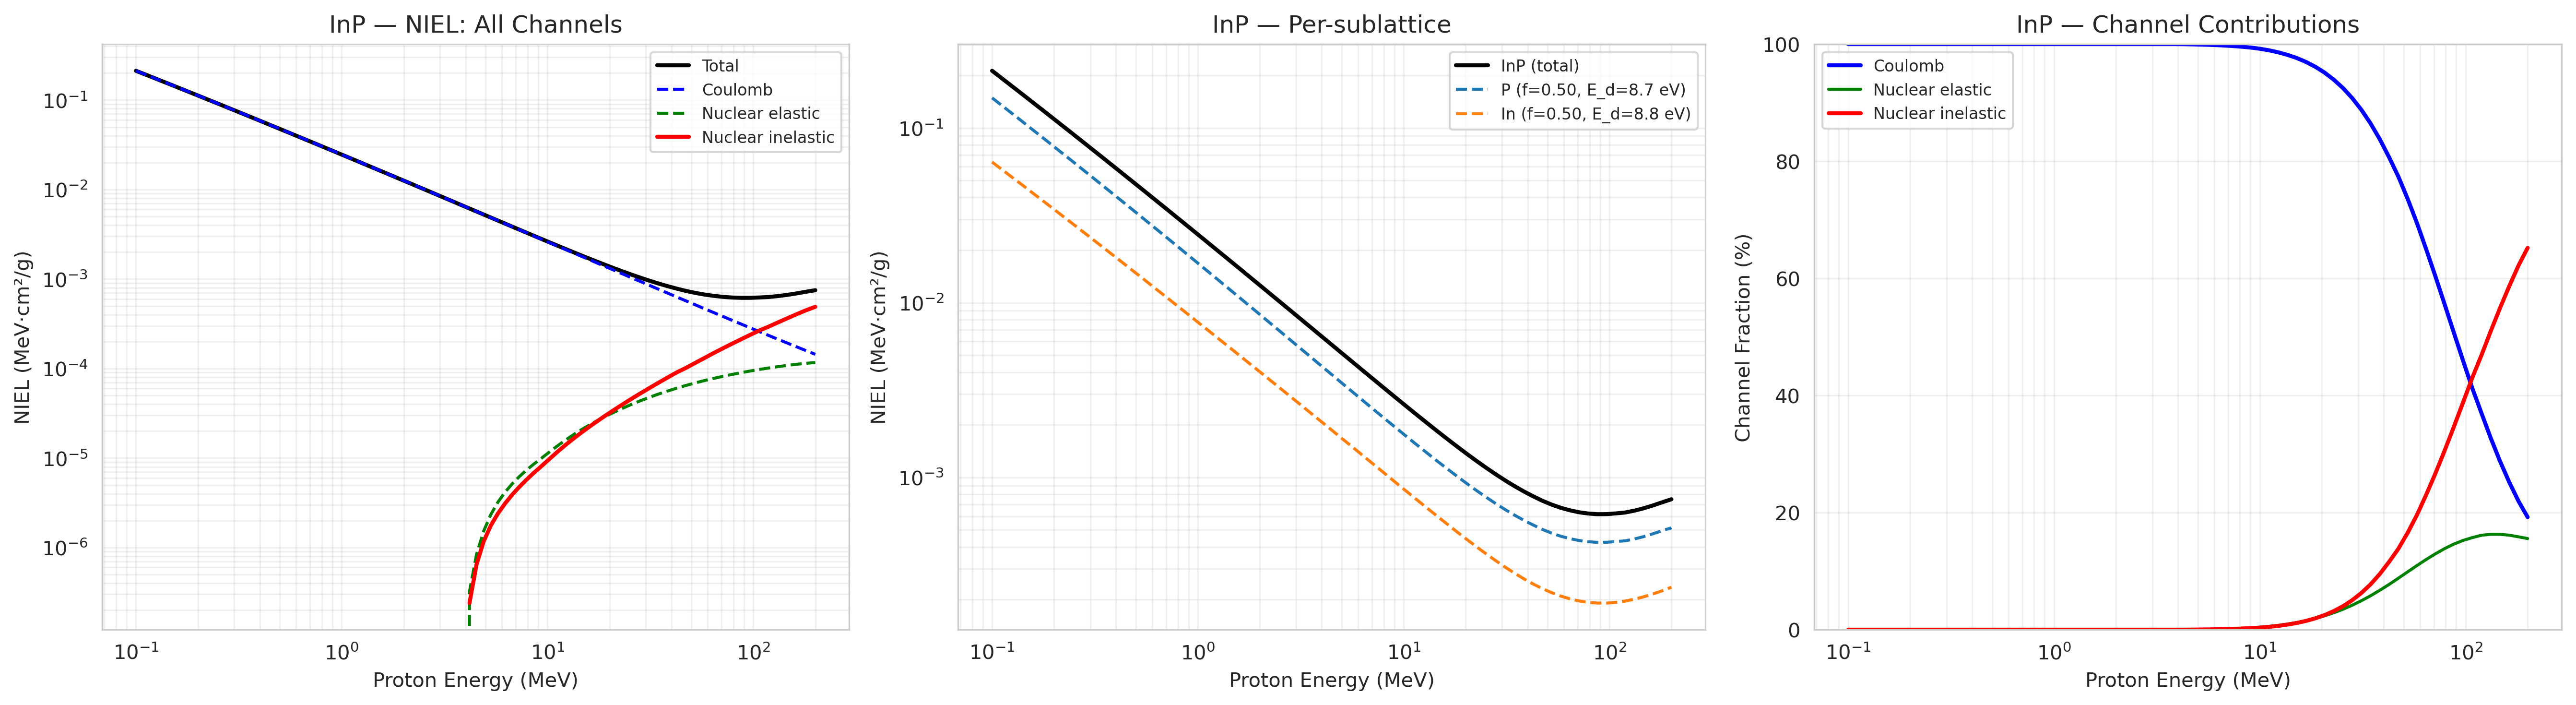


NIEL comparison table:
   E (MeV)        Total      Coulomb    Nuc.Elast     Nuc.Inel  Inel%
      0.10   2.1227e-01   2.1227e-01   0.0000e+00   0.0000e+00   0.0%
      0.48   4.9127e-02   4.9127e-02   0.0000e+00   0.0000e+00   0.0%
      1.00   2.4558e-02   2.4558e-02   0.0000e+00   0.0000e+00   0.0%
      4.89   5.2564e-03   5.2537e-03   1.5287e-06   1.1720e-06   0.0%
     10.00   2.6257e-03   2.6051e-03   1.1253e-05   9.3534e-06   0.4%
     52.22   7.0013e-04   5.1531e-04   6.9096e-05   1.1573e-04  16.5%
     97.05   6.1699e-04   2.8361e-04   9.4040e-05   2.3935e-04  38.8%
    200.00   7.5021e-04   1.4421e-04   1.1678e-04   4.8921e-04  65.2%


In [10]:
from ase.data import atomic_masses, atomic_numbers

# literature displacement threshold energies (eV) per element
# sources: nordlund et al. (2018) j. nucl. mater. 512, 450-479
#          astm e722-14, jun et al. (2003)
ED_DATABASE = {
    'C': 37.0, 'Si': 20.5, 'Ge': 14.5, 'Sn': 12.0,
    'B': 22.0, 'Al': 16.0, 'Ga': 9.4, 'In': 8.8, 'Tl': 7.5,
    'N': 22.0, 'P': 8.7, 'As': 9.8, 'Sb': 9.0, 'Bi': 8.0,
    'Zn': 10.0, 'Cd': 8.0, 'Mg': 10.0, 'Be': 15.0, 'Ca': 8.0,
    'Sr': 7.0, 'Ba': 6.5, 'Hg': 6.0,
    'O': 28.0, 'S': 7.6, 'Se': 7.4, 'Te': 5.5,
    'F': 15.0, 'Cl': 12.0, 'Br': 10.0, 'I': 8.0,
    'Li': 12.0, 'Na': 8.0, 'K': 6.0, 'Rb': 5.5, 'Cs': 5.0,
    'Sc': 25.0, 'Ti': 19.0, 'V': 28.0, 'Cr': 28.0,
    'Mn': 26.0, 'Fe': 17.4, 'Co': 22.0, 'Ni': 23.0, 'Cu': 19.0,
    'Y': 20.0, 'Zr': 21.0, 'Nb': 28.0, 'Mo': 33.0,
    'Tc': 30.0, 'Ru': 28.0, 'Rh': 25.0, 'Pd': 16.0, 'Ag': 16.0,
    'Hf': 30.0, 'Ta': 34.0, 'W': 55.0, 'Re': 40.0,
    'Os': 35.0, 'Ir': 30.0, 'Pt': 22.0, 'Au': 15.0,
    'La': 9.0, 'Ce': 9.0, 'Pr': 9.0, 'Nd': 9.0, 'Pm': 9.0,
    'Sm': 9.0, 'Eu': 9.0, 'Gd': 9.0, 'Tb': 9.0, 'Dy': 9.0,
    'Ho': 9.0, 'Er': 9.0, 'Tm': 9.0, 'Yb': 9.0, 'Lu': 9.0,
    'Pb': 8.0, 'Po': 7.0, 'H': 5.0,
}

def get_Ed(element):
    if element in ED_DATABASE:
        return ED_DATABASE[element]
    Z = atomic_numbers.get(element, 30)
    Ed_est = max(5.0, 35.0 - 0.3 * Z)
    print(f"  WARNING: no literature E_d for {element} (Z={Z}), estimating {Ed_est:.1f} eV")
    return Ed_est

# per-element material properties
elem_list = list(set(ase_atoms.get_chemical_symbols()))
elem_data = {}
for e in elem_list:
    Z = atomic_numbers[e]
    A = atomic_masses[Z]
    Ed = get_Ed(e)
    count = ase_atoms.get_chemical_symbols().count(e)
    frac = count / len(ase_atoms)
    elem_data[e] = {'Z': Z, 'A': A, 'Ed': Ed, 'count': count, 'frac': frac}

avg_mass = np.mean(ase_atoms.get_masses())
avg_Z = np.mean([atomic_numbers[s] for s in ase_atoms.get_chemical_symbols()])
density = dft_density

print(f"material: {formula}")
print(f"avg mass: {avg_mass:.2f} amu, avg Z: {avg_Z:.1f}")
print(f"density: {density:.4f} g/cm³ (from DFT vc-relax)")
print(f"\nper-sublattice displacement thresholds:")
for e, d in elem_data.items():
    print(f"  {e}: Z={d['Z']}, A={d['A']:.2f} amu, E_d={d['Ed']:.1f} eV, fraction={d['frac']:.3f}")


def lindhard_partition(T_eV, Z1, M1, Z2=None, M2=None):
    """lindhard-robinson partition function: fraction of recoil energy to displacements."""
    if Z2 is None: Z2 = Z1
    if M2 is None: M2 = M1
    a_u = 0.8853
    Z_eff = (Z1**(2/3) + Z2**(2/3))**0.5
    epsilon = (a_u * 0.529 / (Z1 * Z2 * 14.4)) * (M2 / (M1 + M2)) * T_eV
    k_L = 0.1337 * Z1**(1/6) * (Z1 * Z2 / Z_eff)**0.5 * ((M1 + M2) / M2)**1.5 / (M1**0.5)
    g = epsilon + 0.40244 * epsilon**(3/4) + 3.4008 * epsilon**(1/6)
    return 1.0 / (1.0 + k_L * g)


def nuclear_elastic_cross_section(E_MeV, Z_target, A_target, Z_proj=1, A_proj=1):
    """proton-nucleus elastic cross-section (cm²) with improved parametrization."""
    r_0 = 1.1e-13
    r_t = r_0 * A_target**(1.0/3.0)
    r_p = r_0 * A_proj**(1.0/3.0)
    R_int = r_t + r_p + 1.2e-13
    E_cm = E_MeV * A_target / (A_proj + A_target)
    V_c = 1.44e-13 * Z_proj * Z_target / R_int
    barrier_width = max(0.3, 0.15 * V_c)
    barrier_transmission = 1.0 / (1.0 + np.exp(-(E_cm - V_c) / barrier_width))
    if barrier_transmission < 1e-10:
        return 0.0
    sigma_R = np.pi * R_int**2 * max(0.0, 1.0 - V_c / E_cm)
    x = E_cm / (25.0 * A_target**(1.0/3.0))
    sigma_R *= (1.0 - np.exp(-x))
    sigma_R *= barrier_transmission
    E_scale = E_cm / (10.0 * A_target**(1.0/3.0))
    ratio_asymptotic = 0.4 + 0.1 * np.exp(-A_target / 100.0)
    elastic_ratio = ratio_asymptotic + (1.0 - ratio_asymptotic) * np.exp(-E_scale)
    sigma_elastic = sigma_R * elastic_ratio
    return max(0.0, sigma_elastic)


def nuclear_elastic_angular_params(E_MeV, A_target, A_proj=1):
    """angular distribution parameters for nuclear elastic scattering."""
    r_0 = 1.1e-13
    hbar_c = 197.3269804e-13
    R_nuc = 0.95e-13 * A_target**(1.0/3.0)
    M_target = A_target * 931.494
    M_proj = A_proj * 931.494
    B_geometric = R_nuc**2 / (2.0 * hbar_c**2)
    E_cm = E_MeV * M_target / (M_proj + M_target)
    mu = M_proj * M_target / (M_proj + M_target)
    p_cm = np.sqrt(2.0 * mu * E_cm)
    kR = p_cm * R_nuc / hbar_c
    B_eff = B_geometric * (1.0 - np.exp(-kR / 3.0))
    b_T = B_eff * 2.0 * M_target
    A_scale = A_target**(1.0/3.0)
    f_diff = 0.3 + 0.4 * (1.0 - np.exp(-E_cm / (50.0 * A_scale)))
    return f_diff, b_T


def calculate_niel_per_element(energies_MeV, Z_target, A_target, Ed_eV,
                                Z_proj=1, A_proj=1.00728,
                                Z_med=None, A_med=None,
                                n_integration=500,
                                include_nuclear=True):
    """calculate proton NIEL with three contributions:
    1. coulomb (screened rutherford + mott)
    2. nuclear elastic (optical model)
    3. nuclear inelastic (compound nucleus model)
    returns (niel_coulomb, niel_nuclear_elastic, niel_nuclear_inelastic) arrays."""
    if Z_med is None: Z_med = Z_target
    if A_med is None: A_med = A_target

    M1_MeV = A_proj * 931.494
    M2_MeV = A_target * 931.494
    e2_MeV_cm = 1.44e-13
    a_0_cm = 0.529177e-8
    a_ZBL = 0.8854 * a_0_cm / (Z_proj**0.23 + Z_target**0.23)
    alpha = 1.0 / 137.036

    niel_coulomb = []
    niel_nuclear_el = []
    niel_nuclear_inel = []

    for E_MeV in energies_MeV:
        gamma = 1.0 + E_MeV / M1_MeV
        beta2 = 1.0 - 1.0 / gamma**2
        beta = np.sqrt(beta2)

        T_max_MeV = (2.0 * M2_MeV * M1_MeV**2 * beta2 * gamma**2) / \
                     (M1_MeV**2 + M2_MeV**2 + 2.0 * gamma * M1_MeV * M2_MeV)
        E_d_MeV = Ed_eV * 1e-6

        if T_max_MeV <= E_d_MeV:
            niel_coulomb.append(0.0)
            niel_nuclear_el.append(0.0)
            niel_nuclear_inel.append(0.0)
            continue

        # === coulomb NIEL (screened rutherford + mott) ===
        E_cm_MeV = E_MeV * M2_MeV / (M1_MeV + M2_MeV)
        b_coul = Z_proj * Z_target * e2_MeV_cm / (2.0 * E_cm_MeV)
        p_MeV = gamma * M1_MeV * beta
        hbar_c_cm = 197.3269804e-13
        theta_screen = hbar_c_cm / (p_MeV * a_ZBL)
        T_screen_MeV = T_max_MeV * theta_screen**2 / 4.0

        log_T = np.linspace(np.log(E_d_MeV), np.log(T_max_MeV), n_integration)
        T_vals = np.exp(log_T)

        integral_C = 0.0
        for i in range(len(T_vals) - 1):
            T = 0.5 * (T_vals[i] + T_vals[i+1])
            dT = T_vals[i+1] - T_vals[i]
            T_eV = T * 1e6
            L = lindhard_partition(T_eV, Z_target, A_target, Z_med, A_med)
            dsigma_dT = np.pi * b_coul**2 * T_max_MeV / (T + T_screen_MeV)**2
            sin2_half = T / T_max_MeV
            sin_half = np.sqrt(max(0, sin2_half))
            cos2_half = 1.0 - sin2_half
            aZ = alpha * Z_target
            mott_corr = (1.0 - beta2 * sin2_half
                        + np.pi * aZ * beta * sin_half * (1.0 - sin_half)
                        - (aZ**2) * (cos2_half - beta2 * sin2_half))
            dsigma_dT *= max(0, mott_corr)
            integral_C += T * L * dsigma_dT * dT

        niel_C = 6.02214076e23 / A_target * integral_C
        niel_coulomb.append(niel_C)

        # === nuclear elastic NIEL ===
        niel_N_el = 0.0
        if include_nuclear:
            sigma_nuc = nuclear_elastic_cross_section(E_MeV, Z_target, A_target, Z_proj, int(round(A_proj)))
            if sigma_nuc > 0:
                f_diff, b_T = nuclear_elastic_angular_params(E_MeV, A_target, A_proj)
                integral_N = 0.0
                for i in range(len(T_vals) - 1):
                    T = 0.5 * (T_vals[i] + T_vals[i+1])
                    dT = T_vals[i+1] - T_vals[i]
                    T_eV = T * 1e6
                    L = lindhard_partition(T_eV, Z_target, A_target, Z_med, A_med)
                    dsigma_diff = 0.0
                    if b_T * T_max_MeV > 0.1:
                        norm_diff = 1.0 / (1.0 - np.exp(-b_T * T_max_MeV))
                        dsigma_diff = sigma_nuc * f_diff * b_T * np.exp(-b_T * T) * norm_diff
                    else:
                        dsigma_diff = sigma_nuc * f_diff / T_max_MeV
                    dsigma_iso = sigma_nuc * (1.0 - f_diff) / T_max_MeV
                    integral_N += T * L * (dsigma_diff + dsigma_iso) * dT
                niel_N_el = 6.02214076e23 / A_target * integral_N
        niel_nuclear_el.append(niel_N_el)

        # === nuclear inelastic NIEL (compound nucleus) ===
        niel_N_inel = 0.0
        if include_nuclear:
            sigma_rxn = nuclear_reaction_cross_section(E_MeV, Z_target, A_target, Z_proj, int(round(A_proj)))
            if sigma_rxn > 0:
                damage_E = nuclear_inelastic_damage_energy(
                    E_MeV, Z_target, A_target, Z_proj, A_proj, Z_med, A_med)
                if damage_E > 0:
                    niel_N_inel = 6.02214076e23 / A_target * sigma_rxn * damage_E
        niel_nuclear_inel.append(niel_N_inel)

    return np.array(niel_coulomb), np.array(niel_nuclear_el), np.array(niel_nuclear_inel)


# ===== compute NIEL =====

energies_MeV = np.unique(np.sort(np.concatenate([
    np.logspace(np.log10(0.1), np.log10(1.0), 20),
    np.logspace(np.log10(1.0), np.log10(10.0), 30),
    np.logspace(np.log10(10.0), np.log10(200.0), 30),
])))

print(f"computing NIEL for {len(energies_MeV)} energies from {energies_MeV[0]:.2f} to {energies_MeV[-1]:.1f} MeV")
print(f"contributions: coulomb + nuclear elastic + nuclear inelastic (compound nucleus)")
print(f"integration: {500} points per energy\n")

niel_coulomb_per_elem = {}
niel_nuc_el_per_elem = {}
niel_nuc_inel_per_elem = {}
niel_total = np.zeros_like(energies_MeV)
niel_coulomb_total = np.zeros_like(energies_MeV)
niel_nuc_el_total = np.zeros_like(energies_MeV)
niel_nuc_inel_total = np.zeros_like(energies_MeV)

for e, d in elem_data.items():
    print(f"  {e} (Z={d['Z']}, A={d['A']:.1f}, E_d={d['Ed']:.1f} eV, f={d['frac']:.3f})...", end=" ")
    niel_C, niel_N_el, niel_N_inel = calculate_niel_per_element(
        energies_MeV,
        Z_target=d['Z'], A_target=d['A'], Ed_eV=d['Ed'],
        Z_proj=1, A_proj=1.00728,
        Z_med=avg_Z, A_med=avg_mass,
        n_integration=500,
        include_nuclear=True
    )
    niel_coulomb_per_elem[e] = niel_C
    niel_nuc_el_per_elem[e] = niel_N_el
    niel_nuc_inel_per_elem[e] = niel_N_inel
    niel_coulomb_total += d['frac'] * niel_C
    niel_nuc_el_total += d['frac'] * niel_N_el
    niel_nuc_inel_total += d['frac'] * niel_N_inel

    niel_10 = np.interp(10, energies_MeV, niel_C + niel_N_el + niel_N_inel)
    print(f"NIEL(10MeV)={niel_10:.4e} [C={np.interp(10,energies_MeV,niel_C):.3e} El={np.interp(10,energies_MeV,niel_N_el):.3e} Inel={np.interp(10,energies_MeV,niel_N_inel):.3e}]")

niel_nuclear_total = niel_nuc_el_total + niel_nuc_inel_total
niel_total = niel_coulomb_total + niel_nuclear_total

print(f"\ntotal NIEL(10 MeV)  = {np.interp(10, energies_MeV, niel_total):.4e} MeV·cm²/g")
print(f"  coulomb           = {np.interp(10, energies_MeV, niel_coulomb_total):.4e}")
print(f"  nuclear elastic   = {np.interp(10, energies_MeV, niel_nuc_el_total):.4e}")
print(f"  nuclear inelastic = {np.interp(10, energies_MeV, niel_nuc_inel_total):.4e}")
nuc_frac_100 = np.interp(100, energies_MeV, niel_nuclear_total) / np.interp(100, energies_MeV, niel_total) * 100
inel_frac_100 = np.interp(100, energies_MeV, niel_nuc_inel_total) / np.interp(100, energies_MeV, niel_total) * 100
print(f"\nat 100 MeV: nuclear fraction={nuc_frac_100:.1f}%, inelastic fraction={inel_frac_100:.1f}%")

# ===== save output =====

omere_output_dir = os.path.join(os.path.dirname(os.getcwd()), "omere_inputs")
os.makedirs(omere_output_dir, exist_ok=True)
omere_file = os.path.join(omere_output_dir, f"{formula}_NIEL.dat")

with open(omere_file, 'w') as f:
    f.write(f"# NIEL for {formula} (protons)\n")
    f.write(f"# density: {density:.4f} g/cm³ (DFT PBE+D3 vc-relaxed)\n")
    f.write(f"# cross-section: coulomb (SR+Mott) + nuclear elastic + nuclear inelastic (compound nucleus)\n")
    f.write(f"# nuclear inelastic: Tripathi reaction XS + Weisskopf evaporation + residual recoil\n")
    f.write(f"# lindhard: two-body robinson partition\n")
    threshold_str = ', '.join(f"{e}={d['Ed']:.1f}eV" for e, d in elem_data.items())
    f.write(f"# displacement thresholds: {threshold_str}\n")
    f.write(f"# references: Jun et al. (2003), Boschini et al. (2011), Tripathi et al. (1999), Nordlund et al. (2018)\n")
    f.write("#\n")
    f.write("# Energy_MeV\tNIEL_total\tNIEL_coulomb\tNIEL_nuc_elastic\tNIEL_nuc_inelastic\n")
    for i, E in enumerate(energies_MeV):
        f.write(f"{E:.6e}\t{niel_total[i]:.6e}\t{niel_coulomb_total[i]:.6e}\t{niel_nuc_el_total[i]:.6e}\t{niel_nuc_inel_total[i]:.6e}\n")

breakdown_file = os.path.join(omere_output_dir, f"{formula}_NIEL_breakdown.dat")
with open(breakdown_file, 'w') as f:
    header = "# Energy_MeV\tNIEL_total\tNIEL_coulomb\tNIEL_nuc_el\tNIEL_nuc_inel"
    for e in elem_data:
        header += f"\tNIEL_{e}_C\tNIEL_{e}_Nel\tNIEL_{e}_Ninel"
    f.write(header + "\n")
    for i, E in enumerate(energies_MeV):
        line = f"{E:.6e}\t{niel_total[i]:.6e}\t{niel_coulomb_total[i]:.6e}\t{niel_nuc_el_total[i]:.6e}\t{niel_nuc_inel_total[i]:.6e}"
        for e in elem_data:
            line += f"\t{niel_coulomb_per_elem[e][i]:.6e}\t{niel_nuc_el_per_elem[e][i]:.6e}\t{niel_nuc_inel_per_elem[e][i]:.6e}"
        f.write(line + "\n")

print(f"\nsaved: {omere_file}")
print(f"saved: {breakdown_file}")

# ===== plots =====

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot 1: total NIEL with all channel breakdown
ax = axes[0]
ax.loglog(energies_MeV, niel_total, 'k-', linewidth=2, label='Total')
ax.loglog(energies_MeV, niel_coulomb_total, 'b--', linewidth=1.5, label='Coulomb')
ax.loglog(energies_MeV, niel_nuc_el_total, 'g--', linewidth=1.5, label='Nuclear elastic')
mask_inel = niel_nuc_inel_total > 0
if np.any(mask_inel):
    ax.loglog(energies_MeV[mask_inel], niel_nuc_inel_total[mask_inel], 'r-', linewidth=2, label='Nuclear inelastic')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('NIEL (MeV·cm²/g)')
ax.set_title(f'{formula} — NIEL: All Channels')
ax.legend(fontsize=8)
ax.grid(True, which='both', alpha=0.3)

# plot 2: per-sublattice
ax = axes[1]
ax.loglog(energies_MeV, niel_total, 'k-', linewidth=2, label=f'{formula} (total)')
for e in elem_data:
    niel_e = elem_data[e]['frac'] * (niel_coulomb_per_elem[e] + niel_nuc_el_per_elem[e] + niel_nuc_inel_per_elem[e])
    ax.loglog(energies_MeV, niel_e, '--',
              label=f'{e} (f={elem_data[e]["frac"]:.2f}, E_d={elem_data[e]["Ed"]:.1f} eV)')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('NIEL (MeV·cm²/g)')
ax.set_title(f'{formula} — Per-sublattice')
ax.legend(fontsize=8)
ax.grid(True, which='both', alpha=0.3)

# plot 3: channel fractions vs energy
ax = axes[2]
with np.errstate(divide='ignore', invalid='ignore'):
    nuc_el_frac = np.where(niel_total > 0, niel_nuc_el_total / niel_total * 100, 0)
    nuc_inel_frac = np.where(niel_total > 0, niel_nuc_inel_total / niel_total * 100, 0)
    coul_frac = np.where(niel_total > 0, niel_coulomb_total / niel_total * 100, 0)
ax.semilogx(energies_MeV, coul_frac, 'b-', linewidth=2, label='Coulomb')
ax.semilogx(energies_MeV, nuc_el_frac, 'g-', linewidth=1.5, label='Nuclear elastic')
ax.semilogx(energies_MeV, nuc_inel_frac, 'r-', linewidth=2, label='Nuclear inelastic')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('Channel Fraction (%)')
ax.set_title(f'{formula} — Channel Contributions')
ax.set_ylim(0, 100)
ax.legend(fontsize=8)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== comparison table =====

print(f"\nNIEL comparison table:")
print(f"{'E (MeV)':>10} {'Total':>12} {'Coulomb':>12} {'Nuc.Elast':>12} {'Nuc.Inel':>12} {'Inel%':>6}")
for E_sel in [0.1, 0.5, 1, 5, 10, 50, 100, 200]:
    idx = np.argmin(np.abs(energies_MeV - E_sel))
    nt = niel_total[idx]
    nc = niel_coulomb_total[idx]
    nne = niel_nuc_el_total[idx]
    nni = niel_nuc_inel_total[idx]
    ni_frac = nni / nt * 100 if nt > 0 else 0
    print(f"{energies_MeV[idx]:10.2f} {nt:12.4e} {nc:12.4e} {nne:12.4e} {nni:12.4e} {ni_frac:5.1f}%")